<a href="https://colab.research.google.com/github/terki-anis/Exercice-de-crunching-data/blob/main/Test_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercice de crunching de data

**Importer les bibliothèques nécessaires**

In [1]:
%matplotlib inline
import os               #os is the library for setting the path
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
!pip install geopandas    #if geopandas is not installed
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 6.3 MB 36.0 MB/s 
     |████████████████████████████████| 15.4 MB 31.6 MB/s 


Chemin pour accéder aux données

In [2]:
os.chdir('/content/drive/MyDrive/Data/data')

Importer les données

In [3]:
tickets=pd.read_csv('ticket_data.csv')
cities=pd.read_csv('cities.csv')
stations=pd.read_csv('stations.csv')
providers=pd.read_csv('providers.csv')

# Analyse des datasets

Le but de cette étape est de mieux comprendre notre dataset et avoir une idée claire sur les différentes variables

Pour mieux comprendre les tableaux et afin d'éviter d'afficher de grands tableaux à chaque fois, on va afficher seulement les colonnes

In [4]:
print('le tableau tickets contient les variables :', tickets.columns)
print('le tableau cities contient les variables :',cities.columns)
print('le tableau stations contient les variables :',stations.columns)
print('le tableau providers contient les variables :',providers.columns)

le tableau tickets contient les variables : Index(['id', 'company', 'o_station', 'd_station', 'departure_ts', 'arrival_ts',
       'price_in_cents', 'search_ts', 'middle_stations', 'other_companies',
       'o_city', 'd_city'],
      dtype='object')
le tableau cities contient les variables : Index(['id', 'local_name', 'unique_name', 'latitude', 'longitude',
       'population'],
      dtype='object')
le tableau stations contient les variables : Index(['id', 'unique_name', 'latitude', 'longitude'], dtype='object')
le tableau providers contient les variables : Index(['id', 'company_id', 'provider_id', 'name', 'fullname', 'has_wifi',
       'has_plug', 'has_adjustable_seats', 'has_bicycle', 'transport_type'],
      dtype='object')


**Le tableau tickets**

In [5]:
tickets.describe()

id       company  ...        o_city        d_city
count  7.416800e+04  74168.000000  ...  74168.000000  74168.000000
mean   6.832108e+06   7109.565527  ...    849.186105    883.776265
std    2.141060e+04   3005.380792  ...   1485.791782   1654.698575
min    6.795025e+06      9.000000  ...      5.000000      1.000000
25%    6.813567e+06   8376.000000  ...    485.000000    453.000000
50%    6.832108e+06   8385.000000  ...    628.000000    562.000000
75%    6.850650e+06   8385.000000  ...    628.000000    628.000000
max    6.869192e+06   8387.000000  ...  12190.000000  12190.000000

[8 rows x 7 columns]

La variable qui nous intèresse le plus est "price_in_cents" car elle représente le prix de chaque trajet. A première vue on peut voir que l'écart type est très grand et donc les données sont disperssé par rapport à la moyenne.

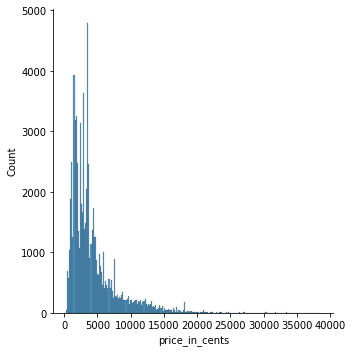

In [6]:
import seaborn as sns
sns.displot(tickets, x="price_in_cents")

Il est claire que l'histogramme est asymétrique à droite, ceci peut être interprété par le fait que la plupart des tickets sont a bas prix (une minorité des tickets coute chère)

**Le tableau cities**

Jettons un coup d'oeil sur les villes avec les déplacements

In [7]:
cities.head()

id                     local_name  ...  longitude  population
0   5159          Padua, Veneto, Italia  ...  11.876761    209678.0
1     76    Barcelona, Cataluña, España  ...   2.173404   1611822.0
2     81    Basel, Basel-Stadt, Schweiz  ...   7.619812         NaN
3    259  Erlangen, Bayern, Deutschland  ...  11.011961    105412.0
4  11979             Balș, Olt, România  ...  24.095672         NaN

[5 rows x 6 columns]

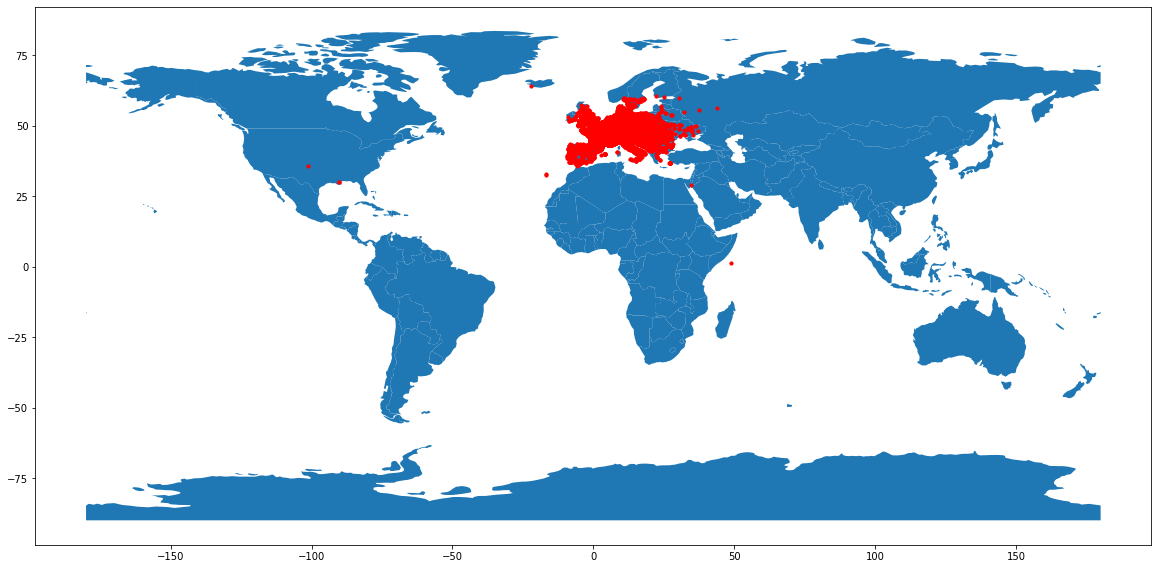

In [8]:
geometry = [Point(xy) for xy in zip(cities['longitude'], cities['latitude'])] #regrouper les coordonnées dans une seule colonne
gdf = GeoDataFrame(cities, geometry=geometry) 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 10)), marker='o', color='red', markersize=10)

On peut voir que les données étudié sont extraits essentiellement de villes d'europe (France, Espagne, Italie...). On peut remarquer l'existance de certains points au milieu de l'océan, ces dernières sont considéré comme des valeurs aberrantes puisqu'il n'existe pas de villes labas.

In [9]:
cities['population'].isnull().sum()

7671

La variable population peut être intéressante à étudier (on peut trouver un lien entre la pouplation d'une ville et les transports utilisé par exemple) ceci dit 95% des valeurs de cette variable sont manquantes, et donc il est difficile de l'exploiter (surtout qu'on possède pas d'une variable bien corrélé avec la population sur laquelle on peut appliquer une regression)

**Le tableau station**

In [10]:
stations.describe()

id      latitude     longitude
count  11035.000000  11035.000000  11035.000000
mean    5518.026914     47.526678      7.580807
std     3185.719813      3.953972     63.655681
min        1.000000    -22.355790    -22.625538
25%     2759.500000     44.896446      1.358655
50%     5518.000000     47.759670      5.824010
75%     8276.500000     50.349956     12.166133
max    11036.000000     64.137571   6645.000000

Cette table donne une idée sur les stations de départs et d'arrivés, on peut voir en analysant l'écrt type des coordonnées que les stations sont relativement proche (comparé au villes). Ensuite cette table contient plus de valeurs que celle de cities, et donc il y a de nombreux trajets dans la même villes.

**La table providers**

Cette table est très intéréssante puisqu'elle contient le entreprises de transports ainsi que le comodités qu'elles offrent.

In [11]:
providers.head()

id  company_id provider_id  ... has_adjustable_seats has_bicycle transport_type
0   9           1         NaN  ...                 True       False            bus
1  10           2         NaN  ...                False       False            bus
2  11           3         NaN  ...                False       False            bus
3  12           4         NaN  ...                False       False            bus
4  13           5         NaN  ...                False       False            bus

[5 rows x 10 columns]

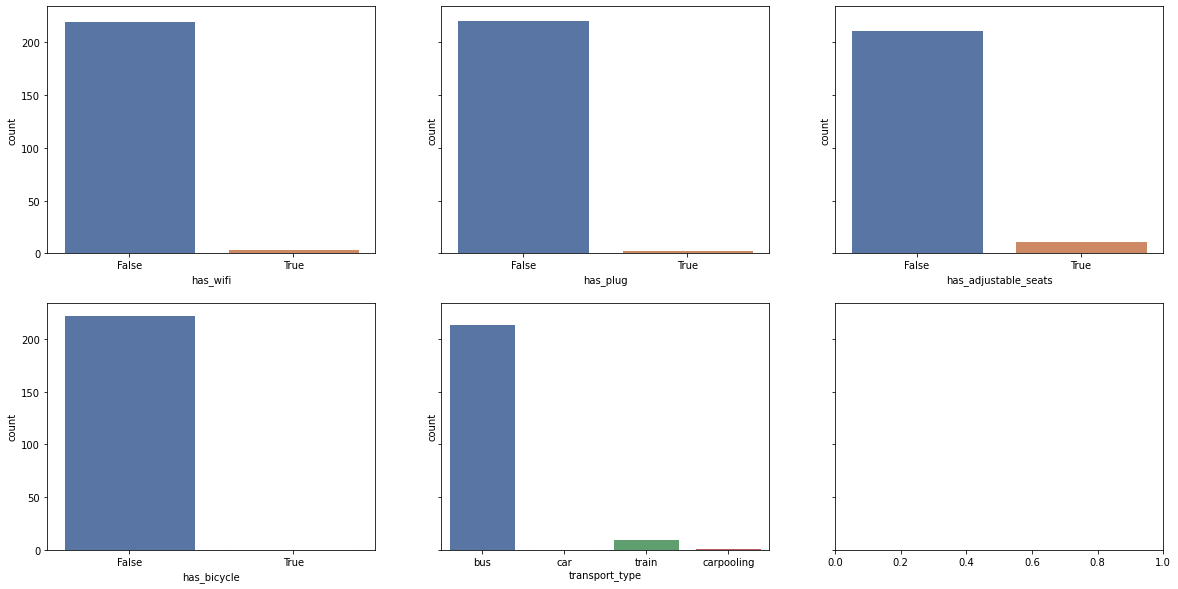

In [12]:
ncount=len(providers)
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
sns.set_theme(style="whitegrid")
sns.countplot(ax=axes[0,0], x="has_wifi", data=providers)
sns.countplot(ax=axes[0,1], x="has_plug", data=providers)
sns.countplot(ax=axes[0,2], x="has_adjustable_seats", data=providers)
sns.countplot(ax=axes[1,0], x="has_bicycle", data=providers)
sns.countplot(ax=axes[1,1], x="transport_type", data=providers)

Ce graphique est très intéressant puisqu'il nous donne une bonne idée sur la distribution des données. On peut voir que la plupart des entreprises n'offrent pas du wifi, ni une prise pour charger ni l'espace pour mettre un vélo, de même peu d'entreprises offrent des sièges ajustables. Ces résultats sont expliqués par le 5ème graphe, qui montre que la plupart des entreprises offrent des trajets en Bus et donc il est logique qu'on ne trouve pas de wifi, plug...

# **Affichage des prix**

In [13]:
print('le prix minimale dun ticket est {:,.2f} dollars'.format(tickets['price_in_cents'].min()/100))
print('le prix maximale dun ticket est {:,.2f} dollars'.format(tickets['price_in_cents'].max()/100))
print('le prix moyen dun ticket est {:,.2f} dollars'.format(tickets['price_in_cents'].mean()/100))

le prix minimale dun ticket est 3.00 dollars
le prix maximale dun ticket est 385.50 dollars
le prix moyen dun ticket est 43.83 dollars


Le prix varie énormément (le prix maximale est égale à plus de 100 fois le min), ceci peut être expliqué par les différentes durées des trajets ainsi que les moyens de transports pris.

**Calcul du temps de trajet**

Avant de calculer la durée de trajet nous allons d'abord transformer nos données en datetime à la place de string

In [14]:
tickets_o=tickets.copy()  #on garde une copie du tableau originale de tickets
tickets['departure_ts']=pd.to_datetime(tickets['departure_ts'])
tickets['arrival_ts']=pd.to_datetime(tickets['arrival_ts'])
#tickets.info() #les variables departure_ts et arrival_ts sont maintenant en date time

On peut voir que les deux colones sont maintenant en datetime
On va donc calculer la durée du trajet

In [15]:
tickets['durée_trjaet']=tickets.arrival_ts -tickets.departure_ts
print('la durée de trajet minimale est',tickets['durée_trjaet'].min())
print('la durée de trajet maximale est',tickets['durée_trjaet'].max())
print('la durée de trajet moyenne est',tickets['durée_trjaet'].mean())

la durée de trajet minimale est 0 days 00:20:00
la durée de trajet maximale est 20 days 12:51:00
la durée de trajet moyenne est 0 days 07:04:37.247600043


La durée maximale du trajet est de 20 jours (ce résultats est assez étonant), Ensuite le trajet moyen est de 7h, ceci veut dire que notre base de données contient beaucoup de longs trajets.

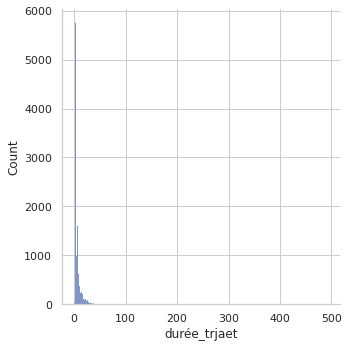

In [59]:
import seaborn as sns
sns.displot(x=tickets["durée_trjaet"].dt.total_seconds() / 3600)

**Calcul de la moyenne de prix et de distance selon le type de transport**

In [16]:
providers['transport_type'].value_counts()

bus           214
train          10
carpooling      2
car             1
Name: transport_type, dtype: int64

Comme on l'a vu plus haut nous avons 4 types de trasports (par bus, par train, par carpooling et en voiture), l'étape suivante est de relier les deux tableaux (tickets et providers) avec les deux colonnes reliant les deux et qui sont "id" et "company"

In [17]:
merged_data=pd.merge(tickets, providers, left_on=tickets['company'], right_on=providers['id'], how='left')

In [18]:
print('le prix moyen dun trajet par carpooling est {:,.2f} $'.format(merged_data[merged_data['transport_type']=="carpooling"]
                                                                     ['price_in_cents'].mean()/100))
print('le prix moyen dun trajet par bus est {:,.2f} $'.format(merged_data[merged_data['transport_type']=="bus"]
                                                              ['price_in_cents'].mean()/100))
print('le prix moyen dun trajet par train est {:,.2f} $'.format(merged_data[merged_data['transport_type']=="train"]
                                                                ['price_in_cents'].mean()/100))

le prix moyen dun trajet par carpooling est 27.42 $
le prix moyen dun trajet par bus est 36.52 $
le prix moyen dun trajet par train est 85.07 $


Le train est le moyen de transport le plus chère. Ensuite il est intéressant de voir que le covoiturage est en moyenne moins chère que le bus

**Les prix en fonction de la distance**

La première étape est le calcul de la distance entre deux stations (de départ et d'arrivé)
Pour cela nous allons crééer une fonction qui calcul la distance entre les coordonnées de longitulde et laltitulde

Afin de déterminer la distance entre la station de départ et la station d'arrivé nous devons concaténer les deux tableaux (tickets et stations) en fonction des noms de stations.

Avant de concatener les tableaux on va jetter un coup d'oeil sur les valeurs manquantes (elles peuvent causer un problème)

Il y a 55.87 % de valeurs mananquantes dans la colonne "o_station"


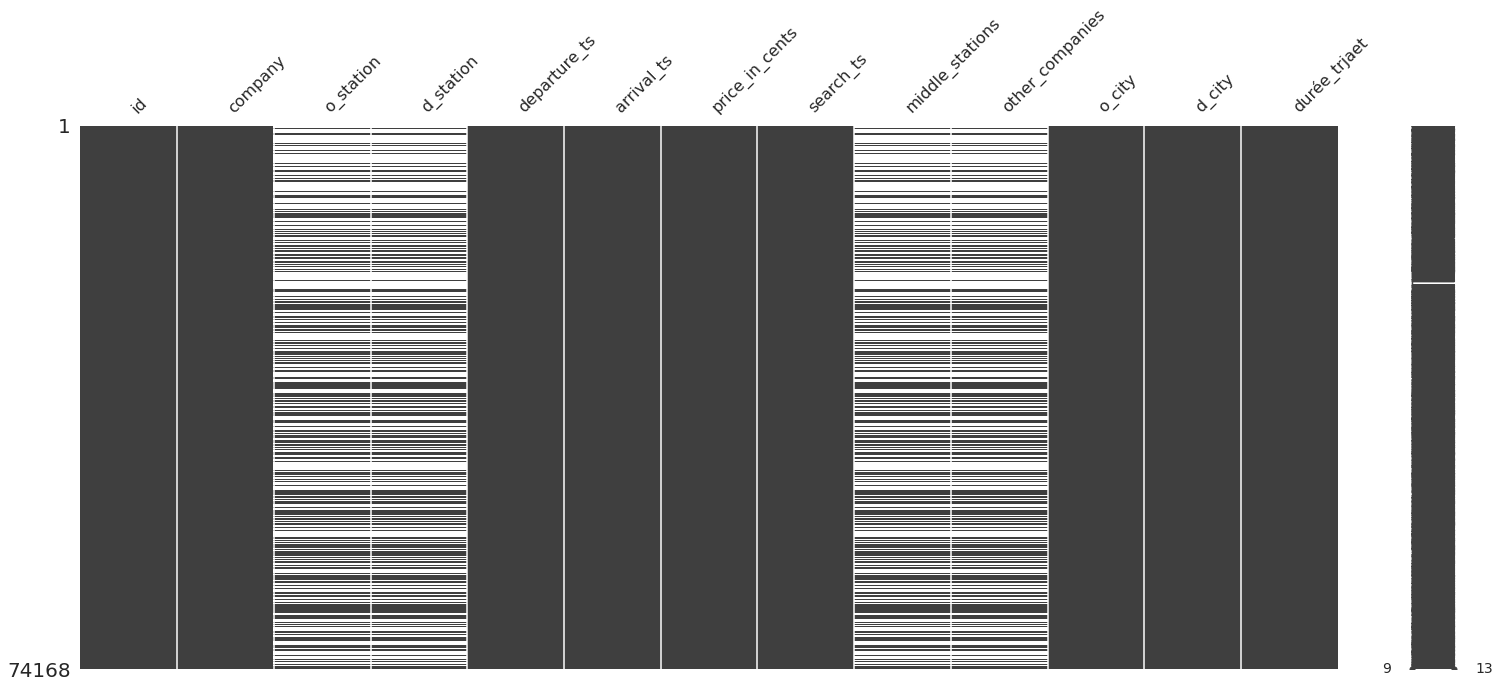

In [19]:
# Visualize missing values as a matrix
msno.matrix(tickets)
print('Il y a {:,.2f} % de valeurs mananquantes dans la colonne "o_station"'
.format(tickets['o_station'].isnull().sum()*100/len(tickets)))

Il y a plusieurs méthodes de traiter les valeurs manquantes, pour le moment on va se contenter d'enlever les lignes qui ne contiennent pas d'information sur les stations de départ et d'arrivé

In [20]:
ticket=tickets.copy() #on recopie le modèle pour garder l'originale
ticket=ticket.dropna()

Maintenant on va joindre les deux tableaux

In [21]:
dist=pd.merge(ticket, stations[['latitude','longitude','unique_name']], left_on=['o_station'], 
              right_on=stations['id'], how='left') #on joint les coordonnées des stations de départ
merged_dist=pd.merge(dist, stations[['latitude','longitude','unique_name']], left_on=['d_station'], right_on=stations['id'],
                     how='left',suffixes=('_départ', '_arrivée')) #jointure des coordonnées des stationsd'arrivé

Une fois le tableau obtenus, passons maintenant au calcul de la distance à partir des coordonnées

In [22]:
#fonction pour le calcul de la distance
def distance(lat1, lat2, lon1, lon2):
  #Convertir des coordonnées en radians
  lon1 = np.deg2rad(lon1)
  lon2 = np.deg2rad(lon2)
  lat1 = np.deg2rad(lat1)
  lat2 = np.deg2rad(lat2)
      
  # Calcul de la distance à l'aide de la méthode de haversine
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  d = 2 * np.arcsin(np.sqrt(a))
  
  #r définie le diamètre de la terre et qui est esttimé a 3956 Kilomètres 
  r = 6371
      
  # la distance finale est donc
  return(d * r)

In [23]:
lo1=merged_dist['longitude_départ']
lo2=merged_dist['longitude_arrivée']
la1=merged_dist['latitude_départ']
la2=merged_dist['latitude_arrivée']
merged_dist['distance']=distance(la1,la2,lo1,lo2)

In [24]:
print('le prix moyen de tickets pour les stations avec les distances entre 0 et 200 km est {:,.2f} $'
      .format(merged_dist[merged_dist['distance'].between(1, 200, inclusive=True)]['price_in_cents'].mean()/100))
print('le prix moyen de tickets pour les stations avec les distances entre 201 et 800 km est {:,.2f} $'
      .format(merged_dist[merged_dist['distance'].between(201, 800, inclusive=True)]['price_in_cents'].mean()/100,'dollars'))
print('le prix moyen de tickets pour les stations avec les distances entre 800 et 2000 km est {:,.2f} $'
      .format(merged_dist[merged_dist['distance'].between(800, 2000, inclusive=True)]['price_in_cents'].mean()/100,'dollars'))
print('le prix moyen de tickets pour les stations avec les distances supérieur a 2000 km est {:,.2f} $'
      .format(merged_dist[merged_dist['distance']>2001]['price_in_cents'].mean()/100,'dollars'))

le prix moyen de tickets pour les stations avec les distances entre 0 et 200 km est 30.63 $
le prix moyen de tickets pour les stations avec les distances entre 201 et 800 km est 68.63 $
le prix moyen de tickets pour les stations avec les distances entre 800 et 2000 km est 89.02 $
le prix moyen de tickets pour les stations avec les distances supérieur a 2000 km est nan $


On peut voir que nous n'avons pas d'information sur les trajets à une distance supérieur à 2000km, Ensuite il est logique de voir le prix augmenter en corrélation avec la distance

Une méthode qui pourrait être considéré pour les valeurs manquantes des stations est de remplacer la coordonnées de la station par celle de la ville pour le départ et l'arrivé, ceci dit les résultats obtenus seront très imprécis et on aura beaucoup de valeur qui se répetnent (pour les mêmes villes de départ et d'arrivé) et beaucoup de zéros pour les trajets dans la même ville.

**Allons un peu plus loins**

On va étudier nos données en affichant la localisation de chaque station

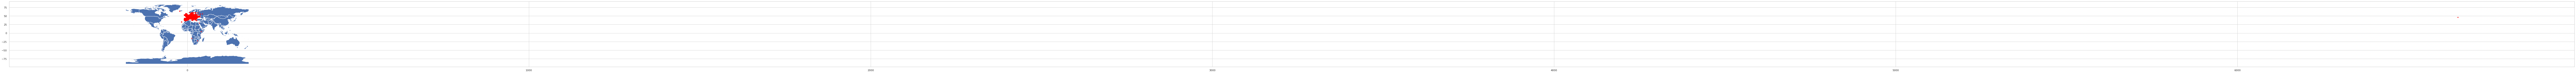

In [25]:
geometry = [Point(xy) for xy in zip(stations['longitude'], stations['latitude'])]
gdf = GeoDataFrame(stations, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(200, 100)), marker='o', color='red', markersize=10)
#taper sur le plot pour une visualisation claire

A premère vu plusières observations peuvent être faites, par exemple les données sont tous de villes de l'europe, ensuite il y a clairement une valeur abhérente sur les coordonnées des stations qui est dans l'extrème droite.
Nous allons localiser cette valeur et l'elever de notre dataset

In [26]:
maxi=stations['longitude'].max() #la valeur maximale est clairement une valeur abhèrente
stations1=stations[stations['longitude']<maxi]

In [27]:
#Affichons la carte encore une fois

geometry = [Point(xy) for xy in zip(stations1['longitude'], stations1['latitude'])]
gdf = GeoDataFrame(stations1, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(200, 100)), marker='o', color='red', markersize=10)

Maintenant que la map est prête on peut visualiser plusieurs choses comme par exemple le plus trajet ou le trajet le plus chère...

In [28]:
#afichons les trajets 
geometry = [Point(xy) for xy in zip(stations1['longitude'], stations1['latitude'])]
gdf = GeoDataFrame(stations1, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(200, 100)), marker='o', color='red', markersize=10)

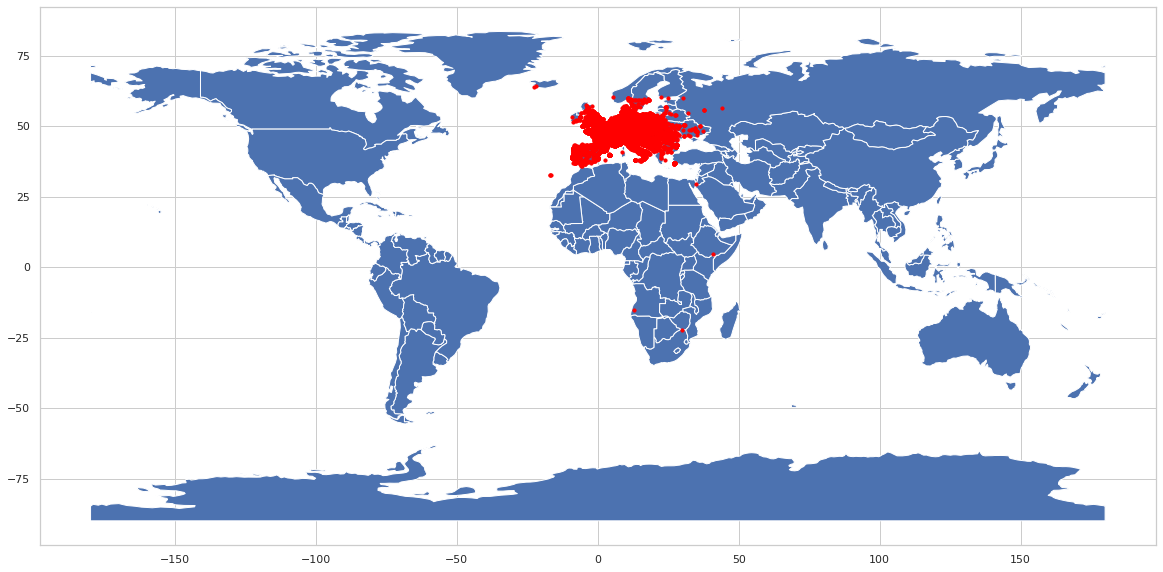

In [69]:
#merged_dist.latitude_départ
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 10)), marker='o', color='red', markersize=10)

**Afficher le plus long trajet**

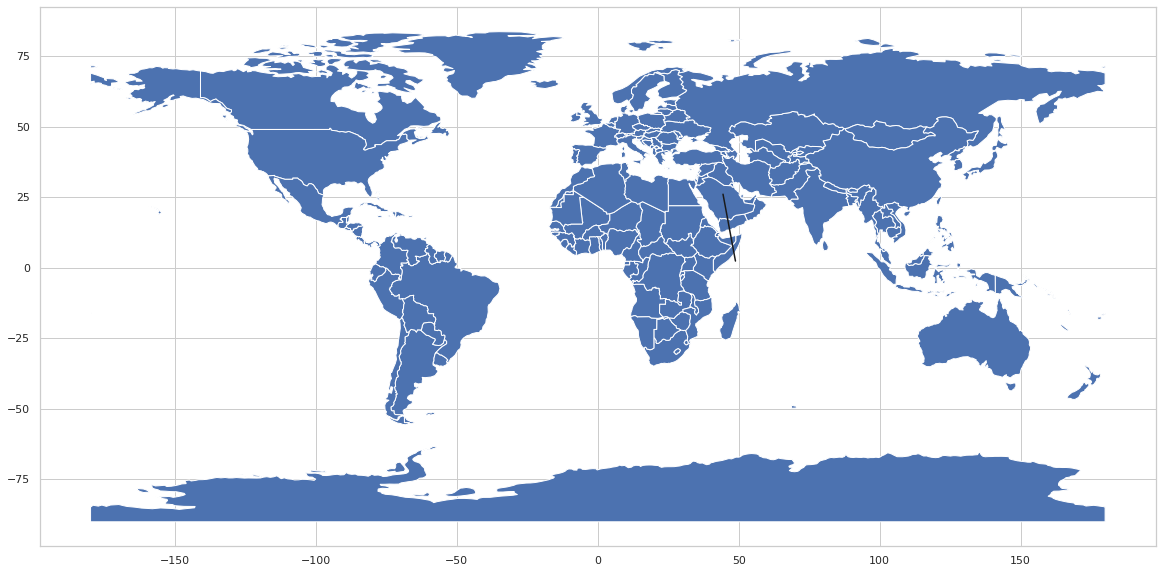

In [73]:
xd=merged_dist.latitude_départ
xa=merged_dist.latitude_arrivée
yd=merged_dist.longitude_départ
ya=merged_dist.longitude_arrivée
#plt.plot(plt.plot([xd,xa], [yd,ya], 'ro-'))
x=[xd,xa]
y=[yd,ya]

def connectpoints(x,y,p1,p2):
    x1, x2 = x[0][p1], x[1][p2]
    y1, y2 = y[0][p1], y[1][p2]
    plt.plot([x1,x2],[y1,y2],'k-')
for i in range(0,32727):
  if (distance(xd[i],xa[i],yd[i],ya[i])==merged_dist['distance'].max()):
    #geometry = [Point(xy) for xy in zip(stations1['longitude'], stations1['latitude'])]
    #gdf = GeoDataFrame(stations1, geometry=geometry)   
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    plt.plot(ax=world.plot(figsize=(20, 10)), marker='o', color='red', markersize=10)
    connectpoints(x,y,i,i)

# Prédiction des prix

On va essayer de prédire les prix des tickets des trajets. 
Ceci dit avant de passer aux algorithmes de prédiction jettons un coup d'oeil sur les variables qui ont une influence sur le prix.

**Y a t-il des companies plus chères que d'autres ?**

In [32]:
#tickets
comp=tickets.groupby(by=['company']).mean()
m_comp=pd.merge(comp, providers, left_on=comp.index, 
              right_on=providers['id'], how='left')

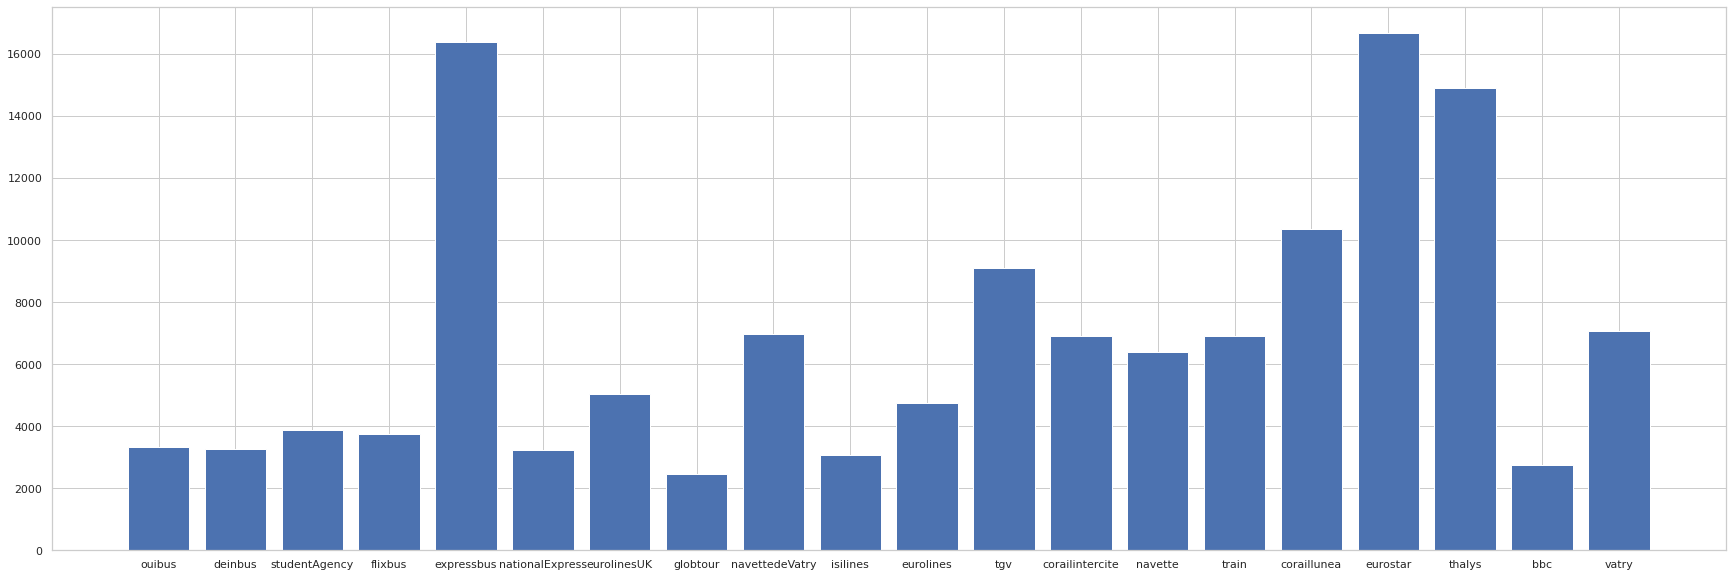

In [33]:
#comp.index[0]
providers[providers['id']==comp.index[0]]
m_comp
plt.figure(figsize=(30,10))
plt.bar(m_comp['name'],m_comp['price_in_cents'])
plt.show()

On peut voir que les compagnies les plus chères sont eurostar, thays et expressbus. Tandis que flixbus, blablacar (bbc), ouibus... possèdent les prix moyenns les moins chère. En effet, il existe d'autres paramètres qui ont une influence sur le prix comme par exemple la longeur du trajet, ceci dit ce graphe nous donne une idée sur les entreprises qui fixent les prix les plus élevé.

# **Let's predict the price**

Quelles variables faut-il utiliser
- A premère vue certaine variables n'ont clairement pas d'influence sur le prix, par exemple la colonne "id" ou "middle_station". Ensuite certaines variables comme  le temps de départ et le temps d'arrivé peuvent être remplacé par la durée du trajet directement.
- Pour le moment nous allons garder toutes les variables à l'exception de "id" et "middle_station". puis par la suite on étudera l'importance de chaque variable pour déterminer lesquelles garder.

In [39]:
df=tickets.copy()
#df=df.drop(['id','middle_stations','search_ts'],1)
#remplaçons les variables départ et arrivé par la durée de trajet
#merged_data.info()
#df[table['id']==station_id].latitude.values[0]
#for i in range(1,len(df)):
  #if (merged['id'])
ids=np.isin(df['id'].values,merged_dist['id'].values,)
a=merged_dist['id'].values

Avant de choisir les varaibles que nous allons utiliser pour l'apprentissage de notre modèle, nous allons d'abbord combiner tout les tableaux afins d'avoir toutes les variables dans un même dataset.

In [40]:
#merged data contient déja les tableaux tickets et providers donc on commence par ce dernier
data=merged_data.copy()
#combinons la table cities
data1=pd.merge(data, cities[['local_name','unique_name','latitude','longitude','population']], left_on=['o_city'], 
              right_on=cities['id'], how='left') #on joint les coordonnées des stations de départ
data2=pd.merge(data1, cities[['local_name','unique_name','latitude','longitude','population']], 
               left_on=['d_city'], right_on=cities['id'],how='left',suffixes=('_ville_départ', '_ville_arrivée'))
#combinons la table stations
data2[['latitude_départ','longitude_départ','unique_name_départ','latitude_arrivée','longitude_arrivée','unique_name_arrivée','distance']]=np.nan
data2.loc[data2.id_x.isin(merged_dist.id), ['latitude_départ','longitude_départ','unique_name_départ',
                                            'latitude_arrivée','longitude_arrivée','unique_name_arrivée',
                                            'distance']] = merged_dist[['latitude_départ','longitude_départ',
                                                                        'unique_name_départ','latitude_arrivée',
                                                                        'longitude_arrivée','unique_name_arrivée','distance']]

Maintenant que notre dataset est prêt il temps de passer au choix des variables que nous allons utiliser pour notre apprentissage

In [41]:
df=data2.copy()
#Il claire que les colonnes des id n'ont aucun effet sur le prix
df=df.drop(['key_0','id_x','company','o_station','d_station','o_city','d_city','id_y','company_id','provider_id'],axis=1)
#Ensuite les noms des villes et des stations n'ont pas d'impact (seul leur coordonnées sont importants)
df=df.drop(['local_name_ville_départ','unique_name_ville_départ','local_name_ville_arrivée','unique_name_ville_arrivée',
            'unique_name_départ','unique_name_arrivée'],axis=1)

Pour le temps de départ et d'arrivé des transport on remplace directement par la durée du transport (en minutes)

In [42]:
df['durée']=(df['arrival_ts']-df['departure_ts']).dt.total_seconds() / 60
df=df.drop(['arrival_ts','departure_ts','search_ts','durée_trjaet'],axis=1)

Pour ce qui suit il s'agit d'un choix personnelles d'enlever certaines colonnes, en effet on peut étudier les middle_stations ainsi que les other_companies (en utilisant les autres tableaux) mais on choisit de ce concentrer seulement sur les autres variables

In [43]:
df=df.drop(['middle_stations','other_companies','fullname','population_ville_départ'],axis=1)
#Ensuite vu le grand nombre des valeurs manquantes de la variable population on décide de ne pas travailler avec cette dernière

**Remarque :** On a gardé la variable 'name' pour les noms des providers puisque cette dernière peu en effet avoir un effet sur le prix (une entreprise de luxe facture plus)

Voila c'est fini ! on a notre base de données.

Il reste seulement à faire le prétraitement et l'apprentissage :)

**Prétraitement des données**

La première étape est de coder les variables catégoriques. Pour cela le choix s'est porté sur le label encoding pour éviter une augumentation de la dimension créée par le One hot encoding par exemple.

In [44]:
label_encoder = preprocessing.LabelEncoder()
categorical_features=['name','has_wifi','has_plug','has_adjustable_seats','has_bicycle','transport_type']
df[categorical_features]=df[categorical_features].apply(label_encoder.fit_transform)

In [45]:
data_X=df.drop(['price_in_cents'],axis=1)
data_Y=df['price_in_cents']

Les valeurs manquantes

Il existe plusieurs méthodes pour remplacer les valeurs manquantes, Dans notre cas et puisque la plupart des valeurs manquantes sont dans les variables des coordonnées une méthode intéressante serait d'utiliser l'algorithme de KNN pour l'imputation des données.

Ceci dit dans notre cas nous allons travailler avec un algorithme comme xgboost qui traite automatiquement les données manquantes.

La standardisation des données n'est pas nécessaire quand on utilise des algorithmes d'apprentissage non sensibles à l'amplitude des variables, ceci dit nous allons quand même standariser les données puisque le but est d'analyser différentes approches.

In [46]:
scaler = StandardScaler()

data_X[data_X.columns.values] = scaler.fit_transform(data_X)

Dévision des ensembles d'apprentissage et du test.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.33, random_state=42)

**Modélisation**

Il exite plusieurs modèles qu'on peut appliquer sur notre problèmatique (xgboost, randomforest, decision trees...). On décide de travailler avec xgboost pour les raisons suivantes :
- Il s'agit d'un problème de régression
-Comme mentionné plus haut, il traite les valeurs manquantes automatiquement.
- Il utilise le calcul parallèle des arbres pour augmenter la rapidité
- Fonctionne bien avec les petits dataset (il réduit l'overfitting)
- on peut faire le tunning des hyperparamètres avec GridSearchCV.

In [48]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(X_train, y_train)
 
ypred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 1678.64


In [49]:
xgbr.score(X_test,y_test)

0.7997349496654034

In [50]:
#optimisation du modèle
from sklearn.model_selection import RandomizedSearchCV
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
#l'apprentissage prend beaucoup de temps (plus d'une heure sans GPU) et donc on le garde en commentaire
#clf.fit(data_X, data_Y)
#print("Best parameters:", clf.best_params_)
#print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Le score obtenus est de 80%, ce résultat est acceptable et peut être amélioré (à l'aide de gridsearch par exemple, ou de tester d'autres algorithmes), Ceci dit le but est de montrer les différentes approches.

**On essai l'imputation des données**

In [53]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
After_imputation = imputer.fit_transform(data_X)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(After_imputation, data_Y, test_size=0.33, random_state=42)
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(X_train, y_train)
 
ypred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 1707.50


On peut voir que le résultat ets similaire (légérement moins bons), ceci veut dire que l'imputation réaliser par xgboost est meilleure. Ceci dit certaine modifications peuvent être approter (comme le choix d'un plus grand nombre de voisin par exemple) mais ceci peut prendre énormément de temps de calcul.

**L'importance des variables**

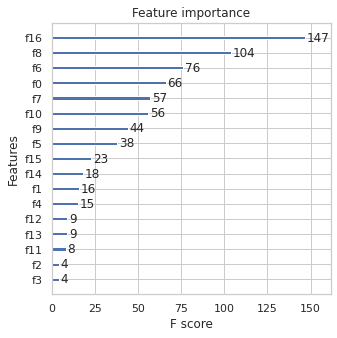

In [78]:
xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

A l'aide de ce graphe on peut voir l'impact de chaque variable sur la détermination du prix, On peut voir que la durée du trajet à le plus d'influence sur le prix du ticket.

**Axes d'amélioration du travail**

Ce travail représente une première approche pour l'analyse des tickets de transports, pour améliorer les résultats obtenus on peut :
- On peut utiliser HalvingGridSearchCV pour le tunning qui est plus rapide et nous permet d'obtenir des résultats optimaux.
- L'utilisation de plusieurs modèle pour la prédiction ( Random Forest, Gradient boosting, Decision Tree...)
- L'enrichissement de notre base de données, on peut remplacer la variable population par les données de population de chaque ville trouvé sur intnet
- Le traitement des valeurs manquantes peut se faire séparément pour chaque variable (knn pour les coordonnées et le mode pour les variables quantitatives et la moyenne pour les variables quantitatives par exemple)

Finalement J'espère que ce travail retiendra votre attention, je reste à votre entière disposition pour un éventuelle entretien ou je pourrais exprimer mes motivations pour le stage proposé.